[Census Documentation](https://www2.census.gov/programs-surveys/acs/tech_docs/subject_definitions/2019_ACSSubjectDefinitions.pdf)

In [1]:
%config Completer.use_jedi = False

In [2]:
from census.factory import getCensus
from census.variables.models import GroupCode
from census.variables.repository.models import GroupSet
from census.models import GeoDomain
import pandas as pd
from pprint import pprint

We'll use these since these are the primary geographies we care about

In [3]:
geoDomains = [GeoDomain('congressional district'), GeoDomain('state')]

In [4]:
c = getCensus(2019, shouldCacheOnDisk=True, shouldLoadFromExistingCache=True, shouldReplaceColumnHeaders=True)

Get the group data

In [5]:
_ = c.getGroups()

In [6]:
from typing import Tuple
from census.client.census import Census

def getStatsHelper(c: Census, group: GroupSet) -> Tuple[pd.DataFrame, pd.DataFrame]:
    variables = c.getVariablesByGroup(group.code)
    filteredVars = [variable['code'] for variable in variables.to_dict('records') if variable['name'].startswith('Estimate')]
    stats = c.getStats(filteredVars, *geoDomains)
    
    pcts = stats.loc[:,['NAME', 'state', 'congressional district']]
    return pcts, stats    

# Education statistics

In [7]:
educPcts, educStats = getStatsHelper(c, c.groups.EducationalAttainmentForThePopulation25YearsAndOver)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [9]:
educPcts['pctNoHs'] = (educStats.Estimate_Total_NoSchoolingCompleted 
                       + educStats.Estimate_Total_NurseryTo4thGrade 
                       + educStats.Estimate_Total_5thAnd6thGrade
                       + educStats.Estimate_Total_7thAnd8thGrade
                       + educStats.Estimate_Total_9thGrade 
                       + educStats.Estimate_Total_10thGrade
                       + educStats.Estimate_Total_11thGrade 
                       + educStats.Estimate_Total_12thGradeNoDiploma) / educStats.Estimate_Total
educPcts['pctHs'] = (educStats.Estimate_Total_RegularHighSchoolDiploma 
                     + educStats.Estimate_Total_GedOrAlternativeCredential) / educStats.Estimate_Total
educPcts['pctBach'] = educStats.Estimate_Total_BachelorsDegree / educStats.Estimate_Total
educPcts['pctSomeCollege1YrNoDegree'] = educStats.Estimate_Total_SomeCollegeLessThan1Year / educStats.Estimate_Total
educPcts['pctSomeCollegeManyYrsNoDegree'] = educStats.Estimate_Total_SomeCollege1OrMoreYearsNoDegree / educStats.Estimate_Total
educPcts['pctGradPlus'] = (educStats.Estimate_Total_DoctorateDegree 
                           + educStats.Estimate_Total_MastersDegree ) / educStats.Estimate_Total

# Employment statistics

In [10]:
emplPcts, emplStats = getStatsHelper(c, c.groups.EmploymentStatusForThePopulation16YearsAndOver)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [11]:
emplPcts['pctInLaborForce'] = (emplStats.Estimate_Total_InLaborForce_CivilianLaborForce / 
                             emplStats.Estimate_Total)
emplPcts['pctEmployed'] = (emplStats.Estimate_Total_InLaborForce_CivilianLaborForce_Employed /
                         emplStats.Estimate_Total_InLaborForce_CivilianLaborForce)
emplPcts['pctUnemployed'] = (emplStats.Estimate_Total_InLaborForce_CivilianLaborForce_Unemployed /
                         emplStats.Estimate_Total_InLaborForce_CivilianLaborForce)

In [12]:
healthInsPct, healthInsStats = getStatsHelper(c, c.groups.HealthInsuranceCoverageStatusBySexByAge)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [13]:
healthInsPct['pctMaleWithIns'] = ( healthInsStats.Estimate_Total_Male_19To64Years_WithHealthInsuranceCoverage /
                                    healthInsStats.Estimate_Total_Male_19To64Years)
healthInsPct['pctFemWithIns'] = ( healthInsStats.Estimate_Total_Female_19To64Years_WithHealthInsuranceCoverage /
                                    healthInsStats.Estimate_Total_Female_19To64Years)
healthInsPct['pctMaleWithoutIns'] = ( healthInsStats.Estimate_Total_Male_19To64Years_NoHealthInsuranceCoverage /
                                    healthInsStats.Estimate_Total_Male_19To64Years)
healthInsPct['pctFemWithoutIns'] = ( healthInsStats.Estimate_Total_Female_19To64Years_NoHealthInsuranceCoverage /
                                    healthInsStats.Estimate_Total_Female_19To64Years)
healthInsPct['pctWithIns'] = (( healthInsStats.Estimate_Total_Male_19To64Years_WithHealthInsuranceCoverage + 
                               healthInsStats.Estimate_Total_Female_19To64Years_WithHealthInsuranceCoverage) /
                                (healthInsStats.Estimate_Total_Male_19To64Years +
                                    healthInsStats.Estimate_Total_Female_19To64Years))
healthInsPct['pctWithoutIns'] = (( healthInsStats.Estimate_Total_Male_19To64Years_NoHealthInsuranceCoverage +
                                  healthInsStats.Estimate_Total_Female_19To64Years_NoHealthInsuranceCoverage) /
                                (healthInsStats.Estimate_Total_Male_19To64Years +
                                    healthInsStats.Estimate_Total_Female_19To64Years))


In [14]:
healthInsPct.head(n=2)

,NAME,state,congressional district,pctMaleWithIns,pctFemWithIns,pctMaleWithoutIns,pctFemWithoutIns,pctWithIns,pctWithoutIns
0,"Congressional District 1 (116th Congress), Alabama",01,01,0.813100,0.856890,0.186900,0.143110,0.836327,0.163673
1,"Congressional District 2 (116th Congress), Alabama",01,02,0.802246,0.860867,0.197754,0.139133,0.833703,0.166297


# Gini Index

In [15]:
_, giniStats = getStatsHelper(c, c.groups.GiniIndexOfIncomeInequality)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [18]:
giniStats.Estimate_GiniIndex.describe()

count    437.000000
mean       0.459643
std        0.031104
min        0.392500
25%        0.439100
50%        0.456200
75%        0.475000
max        0.581900
Name: Estimate_GiniIndex, dtype: float64

# Income

In [19]:
incomeVars = c.getVariablesByGroup(c.groups.AggregateIncomeInThePast12MonthsIn2019InflationAdjustedDollars.code)
incomeData = c.getStats(incomeVars['code'].tolist(), *geoDomains)

populationVars = c.getVariablesByGroup(c.groups.TotalPopulation.code)
populationData = c.getStats(populationVars['code'].tolist(), *geoDomains)

In [20]:
avgIncome = incomeData.loc[:,['NAME', 'state', 'congressional district']]

avgIncome['avgIncome'] = (incomeData.Estimate_AggregateIncomeInThePast12MonthsIn2019InflationAdjustedDollars /
                         populationData.Estimate_Total)

In [21]:
avgIncome.head(n=2)

,NAME,state,congressional district,avgIncome
0,"Congressional District 1 (116th Congress), Alabama",01,01,27463.206159
1,"Congressional District 2 (116th Congress), Alabama",01,02,26790.405233


# Internet access

In [22]:
internetAccessPct, internetAccessStats = getStatsHelper(c, c.groups.PresenceAndTypesOfInternetSubscriptionsInHousehold)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [24]:
internetAccessPct['pctHasInternet'] = (internetAccessStats.Estimate_Total_WithAnInternetSubscription /
                                      internetAccessStats.Estimate_Total)
internetAccessPct['pctHasNoInternet'] = (internetAccessStats.Estimate_Total_NoInternetAccess /
                                        internetAccessStats.Estimate_Total)
internetAccessPct['pctCellData'] = (internetAccessStats.Estimate_Total_WithAnInternetSubscription_CellularDataPlan /
                                   internetAccessStats.Estimate_Total_WithAnInternetSubscription) * internetAccessPct.pctHasInternet

In [28]:
internetAccessPct.head(n=2)

,NAME,state,congressional district,pctHasInternet,pctHasNoInternet,pctCellData
0,"Congressional District 1 (116th Congress), Alabama",01,01,0.805464,0.169390,0.730832
1,"Congressional District 2 (116th Congress), Alabama",01,02,0.820166,0.158101,0.743104


# Tech access

In [29]:
computerPcts, computerStats = getStatsHelper(c, c.groups.TypesOfComputersInHousehold)

In [30]:
computerPcts = computerStats.loc[:,["NAME", "state", "congressional district"]]

computerPcts['pctHasTech'] = (computerStats.Estimate_Total_HasOneOrMoreTypesOfComputingDevices /
                                 computerStats.Estimate_Total)
computerPcts['pctNoTech'] = (computerStats.Estimate_Total_NoComputer / 
                                computerStats.Estimate_Total)
computerPcts['pctSmartphone'] = (computerStats.Estimate_Total_HasOneOrMoreTypesOfComputingDevices_Smartphone /
                               computerStats.Estimate_Total)
computerPcts['pctNoSmartphone'] = 1 - computerPcts.pctSmartphone

In [31]:
computerPcts.head(n=2)

,NAME,state,congressional district,pctHasTech,pctNoTech,pctSmartphone,pctNoSmartphone
0,"Congressional District 1 (116th Congress), Alabama",01,01,0.899878,0.100122,0.832166,0.167834
1,"Congressional District 2 (116th Congress), Alabama",01,02,0.892745,0.107255,0.826951,0.173049


# Language spoken at home

In [32]:
 'LanguageSpokenAtHomeForThePopulation5YearsAndOver',
 'HouseholdLanguageByHouseholdLimitedEnglishSpeakingStatus',

('HouseholdLanguageByHouseholdLimitedEnglishSpeakingStatus',)

# Work commute

In [33]:
transportationVars = c.getVariablesByGroup(c.groups.MeansOfTransportationToWork.code)
transportationStats = c.getStats(transportationVars['code'].tolist(), *geoDomains)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

# Commute time

# Means of transportation by commute time

In [34]:
transByCommuteTimePcts, transByCommuteTimeStats = getStatsHelper(c, c.groups.MeansOfTransportationToWorkByTravelTimeToWork)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [35]:
transByCommuteTimePcts['pctLt10'] = (transByCommuteTimeStats.Estimate_Total_LessThan10Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct10to14'] = (transByCommuteTimeStats.Estimate_Total_10To14Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct15to19'] = (transByCommuteTimeStats.Estimate_Total_15To19Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct20to24'] = (transByCommuteTimeStats.Estimate_Total_20To24Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct25to29'] = (transByCommuteTimeStats.Estimate_Total_25To29Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct30to34'] = (transByCommuteTimeStats.Estimate_Total_30To34Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct35to44'] = (transByCommuteTimeStats.Estimate_Total_35To44Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct44to59'] = (transByCommuteTimeStats.Estimate_Total_45To59Minutes /
                                    transByCommuteTimeStats.Estimate_Total)
transByCommuteTimePcts['pct60plus'] = (transByCommuteTimeStats.Estimate_Total_60OrMoreMinutes /
                                    transByCommuteTimeStats.Estimate_Total)

In [36]:
transByCommuteTimePcts.describe()

,pctLt10,pct10to14,pct15to19,pct20to24,pct25to29,pct30to34,pct35to44,pct44to59,pct60plus
count,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000
mean,0.121342,0.130172,0.149963,0.140375,0.065557,0.137498,0.072203,0.084572,0.098318
std,0.055188,0.034026,0.030290,0.026597,0.016654,0.031528,0.021628,0.032521,0.057980
min,0.020903,0.036667,0.035380,0.061593,0.023220,0.056777,0.019706,0.025861,0.024628
25%,0.079812,0.108312,0.131845,0.122912,0.055837,0.116477,0.056266,0.060898,0.058075
50%,0.113645,0.130965,0.150303,0.139941,0.065057,0.133991,0.070505,0.080233,0.081621
75%,0.148323,0.152541,0.169617,0.154432,0.074629,0.156770,0.086230,0.104302,0.122141
max,0.377546,0.224908,0.246341,0.220081,0.224424,0.251859,0.147998,0.216932,0.384638


# Agg Traveltime

In [37]:
aggTravTimeVars = c.getVariablesByGroup(c.groups.AggregateTravelTimeToWorkInMinutesOfWorkersByTravelTimeToWork.code)
aggTravTimeStats = c.getStats(aggTravTimeVars['code'].tolist(), *geoDomains)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [38]:
avgTravelTime = aggTravTimeStats.loc[:,['NAME', 'state', 'congressional district']]
avgTravelTime['avgTravelTime'] = (aggTravTimeStats.Estimate_AggregateTravelTimeToWorkInMinutes /
                                 populationData.Estimate_Total)

In [39]:
avgTravelTime.describe()

,avgTravelTime
count,437.000000
mean,12.401007
std,2.651061
min,7.789928
25%,10.325869
50%,11.974308
75%,14.145483
max,21.859793


# Poverty

In [40]:
povPcts, povStats = getStatsHelper(c, c.groups.PovertyStatusInThePast12MonthsByAge)

  0%|          | 0/1 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [44]:
povPcts['atOrAbove'] = (povStats.Estimate_Total_IncomeInThePast12MonthsAtOrAbovePovertyLevel /
             povStats.Estimate_Total)

povPcts['below'] = (povStats.Estimate_Total_IncomeInThePast12MonthsBelowPovertyLevel /
                       povStats.Estimate_Total)

In [45]:
geoCodes = c.getGeographyCodes(GeoDomain('state'))

In [46]:
geoCodes[geoCodes['NAME'] == 'New York']

,NAME,state
32,New York,36


In [47]:
congDistCodes = c.getGeographyCodes(GeoDomain('congressional district'),
                                   GeoDomain('state', '36'))

In [51]:
povPcts[(povPcts.state == '36') & (povPcts['congressional district'] == '14')]

,NAME,state,congressional district,atOrAbove,below
271,"Congressional District 14 (116th Congress), New York",36,14,0.871396,0.128604


In [52]:
blackPovPcts, blackPovStats = getStatsHelper(c, c.groups.PovertyStatusInThePast12MonthsByAgeBlackOrAfricanAmericanAlone)

In [53]:
blackPovPcts['atOrAbove'] = (blackPovStats.Estimate_Total_IncomeInThePast12MonthsAtOrAbovePovertyLevel /
             blackPovStats.Estimate_Total)

blackPovPcts['below'] = (blackPovStats.Estimate_Total_IncomeInThePast12MonthsBelowPovertyLevel /
                       blackPovStats.Estimate_Total)

In [54]:
blackPovPcts[(blackPovPcts.state == '36') & (blackPovPcts['congressional district'] == '14')]

,NAME,state,congressional district,atOrAbove,below
271,"Congressional District 14 (116th Congress), New York",36,14,0.830922,0.169078


<AxesSubplot:>

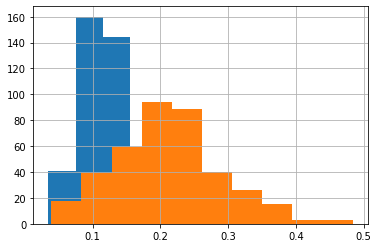

In [56]:
povPcts.below.hist()
blackPovPcts.below.hist()

## Let's look at the each state's % of congressional districts whose poverty rate is >= 16%

In [59]:
povRatesAbove16Pct = povPcts[povPcts.below > .16]

In [60]:
def getStateName(geoCode: str) -> str:
    return geoCodes[geoCodes['state'] == geoCode]['NAME'].tolist()[0]

In [62]:
povRatesPerState = pd.pivot_table(povPcts,
                                  index=['state'],
                                  values=['atOrAbove', 'below'],
                                  aggfunc={
                                      'below': lambda x: (x >= 0.16).sum(),
                                      'atOrAbove': lambda x: (x >= 0.85).sum()
                                  })

In [64]:
# get state names
povRatesPerState['state'] = povRatesPerState.index
povRatesPerState['state'] = povRatesPerState['state'].apply(getStateName)

In [65]:
povRatesPerState = povRatesPerState.rename(columns={'below': 'has 16% poverty or more',
                                                    'atOrAbove': 'has less than 16% poverty'})
povRatesPerState = povRatesPerState[['state', 'has 16% poverty or more', 'has less than 16% poverty']]

In [66]:
povRatesPerState['% districts with more than 16% poverty'] = (povRatesPerState['has 16% poverty or more'] / 
                                                              (povRatesPerState['has 16% poverty or more'] + povRatesPerState['has less than 16% poverty'])) * 100
povRatesPerState['% districts with less than 16% poverty'] = (povRatesPerState['has less than 16% poverty'] / 
                                                              (povRatesPerState['has 16% poverty or more'] + povRatesPerState['has less than 16% poverty'])) * 100
povRatesPerState.head(n=4)

,state,has 16% poverty or more,has less than 16% poverty,% districts with more than 16% poverty,% districts with less than 16% poverty
state,,,,,
01,Alabama,2.0,3.0,40.000000,60.000000
02,Alaska,0.0,1.0,0.000000,100.000000
04,Arizona,3.0,6.0,33.333333,66.666667
05,Arkansas,2.0,2.0,50.000000,50.000000


Merge the data & run some correllations

In [82]:
def mergeAll(*dfs: pd.DataFrame) -> pd.DataFrame:
    """
    merges a lotas dataframes
    """
    if len(dfs) == 2:
        return pd.merge(left=dfs[0], right=dfs[1], on=['NAME', 'state', 'congressional district'])
    
    return pd.merge(left=dfs[0],
                    right=mergeAll(*dfs[1:]),
                    on=['NAME', 'state', 'congressional district'])    

In [71]:
merged = mergeAll(educPcts,
                  internetAccessPct,
                  povPcts,
                  transByCommuteTimePcts,
                  computerPcts,
                  healthInsPct)

In [83]:
merged.corr() # for all US

,pctNoHs,pctHs,pctBach,pctSomeCollege1YrNoDegree,pctSomeCollegeManyYrsNoDegree,pctGradPlus,pctHasInternet,pctHasNoInternet,pctCellData,atOrAbove,...,pctHasTech,pctNoTech,pctSmartphone,pctNoSmartphone,pctMaleWithIns,pctFemWithIns,pctMaleWithoutIns,pctFemWithoutIns,pctWithIns,pctWithoutIns
pctNoHs,1.000000,0.178613,-0.559658,-0.198253,0.105307,-0.531119,-0.483502,0.495252,-0.380003,-0.632966,...,-0.345541,0.345541,-0.079459,0.079459,-0.636688,-0.583428,0.636688,0.583428,-0.616752,0.616752
pctHs,0.178613,1.000000,-0.820182,0.419146,0.099233,-0.725833,-0.669287,0.678132,-0.703422,-0.418958,...,-0.709414,0.709414,-0.767809,0.767809,-0.195847,-0.146895,0.195847,0.146895,-0.172394,0.172394
pctBach,-0.559658,-0.820182,1.000000,-0.456921,-0.388264,0.845960,0.737043,-0.738119,0.734723,0.627792,...,0.665961,-0.665961,0.620782,-0.620782,0.442743,0.377354,-0.442743,-0.377354,0.413622,-0.413622
pctSomeCollege1YrNoDegree,-0.198253,0.419146,-0.456921,1.000000,0.607048,-0.521287,-0.097642,0.080064,-0.188387,0.050867,...,-0.060080,0.060080,-0.236031,0.236031,-0.005456,-0.021610,0.005456,0.021610,-0.013637,0.013637
pctSomeCollegeManyYrsNoDegree,0.105307,0.099233,-0.388264,0.607048,1.000000,-0.526781,-0.135309,0.115832,-0.114802,-0.202400,...,0.022361,-0.022361,0.077350,-0.077350,-0.289918,-0.281142,0.289918,0.281142,-0.287103,0.287103
pctGradPlus,-0.531119,-0.725833,0.845960,-0.521287,-0.526781,1.000000,0.606165,-0.606715,0.595917,0.528281,...,0.511530,-0.511530,0.442343,-0.442343,0.499896,0.456103,-0.499896,-0.456103,0.482663,-0.482663
pctHasInternet,-0.483502,-0.669287,0.737043,-0.097642,-0.135309,0.606165,1.000000,-0.983452,0.910777,0.793046,...,0.893431,-0.893431,0.742097,-0.742097,0.445686,0.380244,-0.445686,-0.380244,0.415513,-0.415513
pctHasNoInternet,0.495252,0.678132,-0.738119,0.080064,0.115832,-0.606715,-0.983452,1.000000,-0.885176,-0.796041,...,-0.914555,0.914555,-0.752421,0.752421,-0.435315,-0.368443,0.435315,0.368443,-0.404304,0.404304
pctCellData,-0.380003,-0.703422,0.734723,-0.188387,-0.114802,0.595917,0.910777,-0.885176,1.000000,0.670116,...,0.828438,-0.828438,0.786643,-0.786643,0.330187,0.269950,-0.330187,-0.269950,0.302236,-0.302236
atOrAbove,-0.632966,-0.418958,0.627792,0.050867,-0.202400,0.528281,0.793046,-0.796041,0.670116,1.000000,...,0.711381,-0.711381,0.485125,-0.485125,0.510455,0.422533,-0.510455,-0.422533,0.469576,-0.469576


In [81]:
sorted(list(c.groups.names()))

['AgeAndNativityOfOwnChildrenUnder18YearsInFamiliesAndSubfamiliesByNativityOfParents',
 'AgeAndNativityOfOwnChildrenUnder18YearsInFamiliesAndSubfamiliesByNumberAndNativityOfParents',
 'AgeByAllocationOfIndependentLivingDifficultyForTheCivilianNoninstitutionalizedPopulation15YearsAndOver',
 'AgeByDisabilityStatusAmericanIndianAndAlaskaNativeAlone',
 'AgeByDisabilityStatusAsianAlone',
 'AgeByDisabilityStatusBlackOrAfricanAmericanAlone',
 'AgeByDisabilityStatusByHealthInsuranceCoverageStatus',
 'AgeByDisabilityStatusByPovertyStatus',
 'AgeByDisabilityStatusHispanicOrLatino',
 'AgeByDisabilityStatusNativeHawaiianAndOtherPacificIslanderAlone',
 'AgeByDisabilityStatusSomeOtherRaceAlone',
 'AgeByDisabilityStatusTwoOrMoreRaces',
 'AgeByDisabilityStatusWhiteAlone',
 'AgeByDisabilityStatusWhiteAloneNotHispanicOrLatino',
 'AgeByLanguageSpokenAtHomeByAbilityToSpeakEnglishForThePopulation5YearsAndOver',
 'AgeByLanguageSpokenAtHomeForThePopulation5YearsAndOver',
 'AgeByLanguageSpokenAtHomeForThePopu

In [84]:
merged[merged['state'] == '01'].corr()

,pctNoHs,pctHs,pctBach,pctSomeCollege1YrNoDegree,pctSomeCollegeManyYrsNoDegree,pctGradPlus,pctHasInternet,pctHasNoInternet,pctCellData,atOrAbove,...,pctHasTech,pctNoTech,pctSmartphone,pctNoSmartphone,pctMaleWithIns,pctFemWithIns,pctMaleWithoutIns,pctFemWithoutIns,pctWithIns,pctWithoutIns
pctNoHs,1.000000,0.747497,-0.931965,0.452109,0.181865,-0.829585,-0.788495,0.823676,-0.701944,-0.495720,...,-0.849613,0.849613,-0.786186,0.786186,-0.552858,-0.627846,0.552858,0.627846,-0.628454,0.628454
pctHs,0.747497,1.000000,-0.921986,-0.005937,0.351503,-0.880621,-0.978407,0.972615,-0.896818,-0.846147,...,-0.892584,0.892584,-0.941879,0.941879,-0.889018,-0.849767,0.889018,0.849767,-0.913342,0.913342
pctBach,-0.931965,-0.921986,1.000000,-0.189513,-0.317885,0.888290,0.939544,-0.954210,0.840406,0.730588,...,0.909021,-0.909021,0.901885,-0.901885,0.770918,0.721374,-0.770918,-0.721374,0.784861,-0.784861
pctSomeCollege1YrNoDegree,0.452109,-0.005937,-0.189513,1.000000,-0.037304,-0.363429,0.058693,0.029306,0.072906,0.316016,...,-0.180996,0.180996,-0.093067,0.093067,-0.074141,-0.317947,0.074141,0.317947,-0.219209,0.219209
pctSomeCollegeManyYrsNoDegree,0.181865,0.351503,-0.317885,-0.037304,1.000000,-0.549643,-0.301930,0.426511,0.071333,-0.207708,...,-0.308172,0.308172,-0.307232,0.307232,-0.468251,-0.191009,0.468251,0.191009,-0.329889,0.329889
pctGradPlus,-0.829585,-0.880621,0.888290,-0.363429,-0.549643,1.000000,0.844064,-0.913534,0.651276,0.589623,...,0.888199,-0.888199,0.879097,-0.879097,0.810272,0.845679,-0.810272,-0.845679,0.873127,-0.873127
pctHasInternet,-0.788495,-0.978407,0.939544,0.058693,-0.301930,0.844064,1.000000,-0.985066,0.918941,0.876779,...,0.934150,-0.934150,0.961696,-0.961696,0.796685,0.785012,-0.796685,-0.785012,0.832886,-0.832886
pctHasNoInternet,0.823676,0.972615,-0.954210,0.029306,0.426511,-0.913534,-0.985066,1.000000,-0.846095,-0.810738,...,-0.945067,0.945067,-0.957101,0.957101,-0.804862,-0.789633,0.804862,0.789633,-0.839264,0.839264
pctCellData,-0.701944,-0.896818,0.840406,0.072906,0.071333,0.651276,0.918941,-0.846095,1.000000,0.872492,...,0.825818,-0.825818,0.877854,-0.877854,0.718223,0.764691,-0.718223,-0.764691,0.784381,-0.784381
atOrAbove,-0.495720,-0.846147,0.730588,0.316016,-0.207708,0.589623,0.876779,-0.810738,0.872492,1.000000,...,0.793612,-0.793612,0.868634,-0.868634,0.761739,0.659039,-0.761739,-0.659039,0.741644,-0.741644
